In [1]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
!tar -xjf LJSpeech-1.1.tar.bz2

--2021-12-01 17:57:00--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 174.138.79.61
Connecting to data.keithito.com (data.keithito.com)|174.138.79.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [application/octet-stream]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  46.8MB/s    in 58s     

2021-12-01 17:57:58 (45.3 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [2]:
!pip install librosa

In [152]:
!pip install torch==1.10.0+cu111 torchaudio==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
!git clone https://github.com/NVIDIA/waveglow.git
!pip install googledrivedownloader

Cloning into 'waveglow'...
remote: Enumerating objects: 190, done.
remote: Total 190 (delta 0), reused 0 (delta 0), pack-reused 190
Receiving objects: 100% (190/190), 435.59 KiB | 14.05 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [153]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [154]:
gdd.download_file_from_google_drive(
    file_id='1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF',
    dest_path='./waveglow_256channels_universal_v5.pt'
)

In [155]:
import torch
import librosa
import torchaudio
from torch import nn
from dataclasses import dataclass
from typing import Tuple, Optional, List, Union
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

# Model + utils

In [156]:
@dataclass
class Batch:
    waveform: torch.Tensor
    waveforn_length: torch.Tensor
    transcript: List[str]
    tokens: torch.Tensor
    token_lengths: torch.Tensor
    durations: Optional[torch.Tensor] = None

    def to(self, device: torch.device) -> 'Batch':
        self.waveform = self.waveform.to(device)
        self.tokens = self.tokens.to(device)
        return self


class LJSpeechCollator:

    def __call__(self, instances: List[Tuple]) -> Batch:
        waveform, waveforn_length, transcript, tokens, token_lengths = list(
            zip(*instances)
        )

        waveform = pad_sequence([
            waveform_[0] for waveform_ in waveform
        ]).transpose(0, 1)
        waveforn_length = torch.cat(waveforn_length)

        tokens = pad_sequence([
            tokens_[0] for tokens_ in tokens
        ]).transpose(0, 1)
        token_lengths = torch.cat(token_lengths)

        return Batch(waveform, waveforn_length, transcript, tokens, token_lengths)

In [157]:
class LJSpeechDataset(torchaudio.datasets.LJSPEECH):

    def __init__(self, root):
        super().__init__(root=root)
        self._tokenizer = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH.get_text_processor()

    def __getitem__(self, index: int):
        waveform, _, _, transcript = super().__getitem__(index)
        waveforn_length = torch.tensor([waveform.shape[-1]]).int()

        tokens, token_lengths = self._tokenizer(transcript)

        return waveform, waveforn_length, transcript, tokens, token_lengths

    def decode(self, tokens, lengths):
        result = []
        for tokens_, length in zip(tokens, lengths):
            text = "".join([
                self._tokenizer.tokens[token]
                for token in tokens_[:length]
            ])
            result.append(text)
        return result

In [158]:
class Loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mel_mse = nn.MSELoss()
        self.dur_mse = nn.MSELoss()

    def forward(self, duration, pred_duration, spectrogram, pred_spectrogram):
        min_dur = min(duration.shape[-1], pred_duration.shape[-1])
        dur_loss = self.dur_mse(duration[:, :min_dur], pred_duration.exp()[:, :min_dur])
        min_mel = min(spectrogram.shape[-1], pred_spectrogram.shape[-1])
        mel_loss = self.mel_mse(spectrogram[:, :, :min_mel], pred_spectrogram[:, :, :min_mel])
        return dur_loss, mel_loss

In [159]:
@dataclass
class MelSpectrogramConfig:
    sr: int = 22050
    win_length: int = 1024
    hop_length: int = 256
    n_fft: int = 1024
    f_min: int = 0
    f_max: int = 8000
    n_mels: int = 80
    power: float = 1.0

    # value of melspectrograms if we fed a silence into `MelSpectrogram`
    pad_value: float = -11.5129251


class MelSpectrogram(nn.Module):

    def __init__(self, config: MelSpectrogramConfig):
        super(MelSpectrogram, self).__init__()

        self.config = config

        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=config.sr,
            win_length=config.win_length,
            hop_length=config.hop_length,
            n_fft=config.n_fft,
            f_min=config.f_min,
            f_max=config.f_max,
            n_mels=config.n_mels
        )

        # The is no way to set power in constructor in 0.5.0 version.
        self.mel_spectrogram.spectrogram.power = config.power

        # Default `torchaudio` mel basis uses HTK formula. In order to be compatible with WaveGlow
        # we decided to use Slaney one instead (as well as `librosa` does by default).
        mel_basis = librosa.filters.mel(
            sr=config.sr,
            n_fft=config.n_fft,
            n_mels=config.n_mels,
            fmin=config.f_min,
            fmax=config.f_max
        ).T
        self.mel_spectrogram.mel_scale.fb.copy_(torch.tensor(mel_basis))

    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        """
        :param audio: Expected shape is [B, T]
        :return: Shape is [B, n_mels, T']
        """

        mel = self.mel_spectrogram(audio) \
            .clamp_(min=1e-5) \
            .log_()

        return mel

In [160]:
import warnings
import sys
sys.path.append('waveglow/')

warnings.filterwarnings('ignore')


class Vocoder(nn.Module):

    def __init__(self):
        super(Vocoder, self).__init__()

        model = torch.load('waveglow_256channels_universal_v5.pt', map_location='cpu')[
            'model']
        self.net = model.remove_weightnorm(model)

    @torch.no_grad()
    def inference(self, spect: torch.Tensor):
        spect = self.net.upsample(spect)

        # trim the conv artifacts
        time_cutoff = self.net.upsample.kernel_size[0] - \
            self.net.upsample.stride[0]
        spect = spect[:, :, :-time_cutoff]

        spect = spect.unfold(2, self.net.n_group, self.net.n_group) \
            .permute(0, 2, 1, 3) \
            .contiguous() \
            .flatten(start_dim=2) \
            .transpose(-1, -2)

        # generate prior
        audio = torch.randn(spect.size(0), self.net.n_remaining_channels, spect.size(-1)) \
            .to(spect.device)

        for k in reversed(range(self.net.n_flows)):
            n_half = int(audio.size(1) / 2)
            audio_0 = audio[:, :n_half, :]
            audio_1 = audio[:, n_half:, :]

            output = self.net.WN[k]((audio_0, spect))

            s = output[:, n_half:, :]
            b = output[:, :n_half, :]
            audio_1 = (audio_1 - b) / torch.exp(s)
            audio = torch.cat([audio_0, audio_1], 1)

            audio = self.net.convinv[k](audio, reverse=True)

            if k % self.net.n_early_every == 0 and k > 0:
                z = torch.randn(
                    spect.size(0), self.net.n_early_size, spect.size(2),
                    device=spect.device
                )
                audio = torch.cat((z, audio), 1)

        audio = audio.permute(0, 2, 1) \
            .contiguous() \
            .view(audio.size(0), -1)

        return audio

In [161]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


class GraphemeAligner(nn.Module):

    def __init__(self):
        super().__init__()

        self._wav2vec2 = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()
        self._labels = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_labels()
        self._char2index = {c: i for i, c in enumerate(self._labels)}
        self._unk_index = self._char2index['<unk>']
        self._resampler = torchaudio.transforms.Resample(
            orig_freq=MelSpectrogramConfig.sr, new_freq=16_000
        )

    def _decode_text(self, text):
        text = text.replace(' ', '|').upper()
        return torch.tensor([
            self._char2index.get(char, self._unk_index)
            for char in text
        ]).long()

    @torch.no_grad()
    def forward(
            self,
            wavs: torch.Tensor,
            wav_lengths: torch.Tensor,
            texts: Union[str, List[str]]
    ):
        if isinstance(texts, str):
            texts = [texts]
        batch_size = wavs.shape[0]

        durations = []
        for index in range(batch_size):
            current_wav = wavs[index, :wav_lengths[index]].unsqueeze(dim=0)
            current_wav = self._resampler(current_wav)
            emission, _ = self._wav2vec2(current_wav)
            emission = emission.log_softmax(dim=-1).squeeze(dim=0).cpu()

            tokens = self._decode_text(texts[index])

            trellis = self._get_trellis(emission, tokens)
            path = self._backtrack(trellis, emission, tokens)
            segments = self._merge_repeats(texts[index], path)

            num_frames = emission.shape[0]
            relative_durations = torch.tensor([
                segment.length / num_frames for segment in segments
            ])

            durations.append(relative_durations)

        durations = pad_sequence(durations).transpose(0, 1)
        return durations

    def _get_trellis(self, emission, tokens, blank_id=0):
        num_frame = emission.size(0)
        num_tokens = len(tokens)

        # Trellis has extra dimension for both time axis and tokens.
        # The extra dim for tokens represents <SoS> (start-of-sentence)
        # The extra dim for time axis is for simplification of the code.
        trellis = torch.full((num_frame + 1, num_tokens + 1), -float('inf'))
        trellis[:, 0] = 0
        for t in range(num_frame):
            trellis[t + 1, 1:] = torch.maximum(
                # Score for staying at the same token
                trellis[t, 1:] + emission[t, blank_id],

                # Score for changing to the next token
                trellis[t, :-1] + emission[t, tokens],
            )
        return trellis

    def _backtrack(self, trellis, emission, tokens, blank_id=0):
        # Note:
        # j and t are indices for trellis, which has extra dimensions
        # for time and tokens at the beginning.
        # When refering to time frame index `T` in trellis,
        # the corresponding index in emission is `T-1`.
        # Similarly, when refering to token index `J` in trellis,
        # the corresponding index in transcript is `J-1`.
        j = trellis.size(1) - 1
        t_start = torch.argmax(trellis[:, j]).item()

        path = []
        for t in range(t_start, 0, -1):
            # 1. Figure out if the current position was stay or change
            # Note (again):
            # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
            # Score for token staying the same from time frame J-1 to T.
            stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
            # Score for token changing from C-1 at T-1 to J at T.
            changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

            # 2. Store the path with frame-wise probability.
            prob = emission[t - 1, tokens[j - 1]
            if changed > stayed else 0].exp().item()
            # Return token index and time index in non-trellis coordinate.
            path.append(Point(j - 1, t - 1, prob))

            # 3. Update the token
            if changed > stayed:
                j -= 1
                if j == 0:
                    break

        else:
            raise ValueError('Failed to align')

        return path[::-1]

    def _merge_repeats(self, text, path):
        i1, i2 = 0, 0
        segments = []
        while i1 < len(path):
            while i2 < len(path) and path[i1].token_index == path[i2].token_index:
                i2 += 1
            score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
            segments.append(
                Segment(
                    text[path[i1].token_index],
                    path[i1].time_index,
                    path[i2 - 1].time_index + 1,
                    score
                )
            )
            i1 = i2

        return segments

    @staticmethod
    def plot_trellis_with_path(trellis, path):
        # to plot trellis with path, we take advantage of 'nan' value
        trellis_with_path = trellis.clone()
        for i, p in enumerate(path):
            trellis_with_path[p.time_index, p.token_index] = float('nan')
        plt.imshow(trellis_with_path[1:, 1:].T, origin='lower')

In [204]:
from torch import nn
import torch
import math


class PositionalEncoding(nn.Module):

    ### https://pytorch.org/tutorials/beginner/transformer_tutorial.html#define-the-model 

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_heads = n_heads

        self.W_O = nn.Linear(hidden_size * n_heads, hidden_size)
        self.W_Q = nn.Linear(hidden_size, hidden_size * n_heads)
        self.W_K = nn.Linear(hidden_size, hidden_size * n_heads)
        self.W_V = nn.Linear(hidden_size, hidden_size * n_heads)

    def forward(self, x):
        q = self.W_Q(x).view(x.shape[0], x.shape[1], self.n_heads, self.hidden_size).transpose(1, 2)
        k = self.W_K(x).view(x.shape[0], x.shape[1], self.n_heads, self.hidden_size).transpose(1, 2)
        v = self.W_V(x).view(x.shape[0], x.shape[1], self.n_heads, self.hidden_size).transpose(1, 2)

        res = (torch.matmul(q, k.transpose(3, 2)) / math.sqrt(self.hidden_size)).softmax(dim=-1)
        res = torch.matmul(res, v).transpose(1, 2).contiguous().view(x.shape[0], x.shape[1], -1)
        return self.W_O(res)


class FFTBlock(nn.Module):
    def __init__(self, in_feats, conv_hidden_size, kernel_size, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(n_heads, in_feats)
        self.ln1 = nn.LayerNorm(in_feats)
        self.ln2 = nn.LayerNorm(in_feats)
        self.conv = nn.Sequential(
            nn.Conv1d(
                in_channels=in_feats, out_channels=conv_hidden_size, kernel_size=kernel_size, padding=kernel_size//2
            ),
            nn.ReLU(),
            nn.Conv1d(
                in_channels=conv_hidden_size, out_channels=in_feats, kernel_size=kernel_size, padding=kernel_size // 2
            )
        )

    def forward(self, x):
        res = x
        x = self.attention(self.ln1(x))
        x += res
        res = x
        x = self.ln2(x)
        x = self.conv(x.transpose(1, 2)).transpose(1, 2)
        x += res
        return x


class FFT(nn.Module):
    def __init__(self, n_blocks, n_heads, in_feats, conv_hidden_size, kernel_size, dropout, max_len=5000):
        super().__init__()
        self.pe = PositionalEncoding(in_feats, dropout, max_len)
        self.blocks = nn.Sequential(*[
            FFTBlock(
                in_feats, conv_hidden_size, kernel_size, n_heads
            ) for _ in range(n_blocks)
        ])
        self.ln = nn.LayerNorm(in_feats)

    def forward(self, x):
        x = self.pe(x)
        x = self.blocks(x)
        x = self.ln(x)
        return x


class DurationPredictor(nn.Module):
    def __init__(self, in_feats, conv_hidden_size, kernel_size, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_feats, conv_hidden_size, kernel_size, padding=kernel_size // 2)
        self.ln1 = nn.LayerNorm(conv_hidden_size)
        self.conv2 = nn.Conv1d(conv_hidden_size, conv_hidden_size, kernel_size, padding=kernel_size // 2)
        self.ln2 = nn.LayerNorm(conv_hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(conv_hidden_size, 1)

    def forward(self, x):
        x = self.conv1(x.transpose(-2, -1))
        x = self.dropout(self.relu(self.ln1(x.transpose(-2, -1))))

        x = self.conv2(x.transpose(-2, -1))
        x = self.dropout(self.relu(self.ln2(x.transpose(-2, -1))))

        x = torch.exp(self.linear(x).squeeze(-1))
        return x

class LengthRegulator(nn.Module):
    def __init__(self, in_feats, conv_hidden_size, kernel_size, dropout):
        super().__init__()
        self.dp = DurationPredictor(in_feats, conv_hidden_size, kernel_size, dropout)
    
    def forward(self, x, durations):
        pred_dur = self.dp(x)
        res = []
        if self.training:
            cur_dur = torch.round(durations).int()
        else:
            cur_dur = torch.round(pred_dur).int()
        for i in range(x.shape[0]):
            res.append(torch.repeat_interleave(x[i], cur_dur[i], 0))
        res = pad_sequence(res, batch_first=True)
        return res, pred_dur


class FastSpeech(nn.Module):
    def __init__(self, vocab_size=51, ph_blocks=6, mel_blocks=6, hidden_size=384, n_heads=2, kernel_size=3,
                 conv_hidden_size=1536, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, hidden_size)
        self.fft_ph = FFT(ph_blocks, n_heads, hidden_size, conv_hidden_size, kernel_size, dropout)
        self.lr = LengthRegulator(hidden_size, hidden_size, kernel_size, dropout)
        self.fft_mel = FFT(mel_blocks, n_heads, hidden_size, conv_hidden_size, kernel_size, dropout)
        self.l = nn.Linear(hidden_size, 80)
    
    def forward(self, x, durations):
        x = self.emb(x)
        x = self.fft_ph(x)
        x, pred_dur = self.lr(x, durations)
        x = self.fft_mel(x)
        return self.l(x), pred_dur

# Train

In [205]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
featurizer = MelSpectrogram(MelSpectrogramConfig())

In [206]:
from torch.utils.data import DataLoader
from itertools import islice
dataloader = DataLoader(LJSpeechDataset('.'), batch_size=3, collate_fn=LJSpeechCollator())

In [207]:
dummy_batch = list(islice(dataloader, 1))[0]
aligner = GraphemeAligner().to(device)
dummy_batch.durations = aligner(
    dummy_batch.waveform.to(device), dummy_batch.waveforn_length, dummy_batch.transcript
)
tokens = dummy_batch.tokens.to(device)
waveform = dummy_batch.waveform
mels = featurizer(waveform).to(device)
mel_len = mels.shape[-1] - (mels == -11.5129251)[:, 0, :].sum(dim=-1)
mels = mels.transpose(1, 2)
durs = dummy_batch.durations.to(device) * mel_len.unsqueeze(1).expand(-1, dummy_batch.durations.size(-1)).to(device)

In [212]:
from tqdm import tqdm

n_epochs = 3000
model = FastSpeech().to(device)
model.train()
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

for i in tqdm(range(n_epochs)):
    opt.zero_grad()
    preds, dur_preds = model(tokens, durs)
    dur_loss = nn.MSELoss()(durs, dur_preds)
    min_mel = min(mels.shape[1], preds.shape[1])
    mel_loss = nn.MSELoss()(mels[:, :min_mel, :], preds[:, :min_mel, :])
    loss = dur_loss + mel_loss
    loss.backward()
    opt.step()
    if (i + 1) % 100 == 0:
        print('duration loss:', dur_loss.item(), '\t', 'melspec loss:', mel_loss.item())

  3%|▎         | 101/3000 [00:14<07:07,  6.79it/s]

duration loss: 2.148118257522583 	 melspec loss: 4.0566205978393555


  7%|▋         | 201/3000 [00:29<06:55,  6.74it/s]

duration loss: 0.7743396759033203 	 melspec loss: 1.8311117887496948


 10%|█         | 301/3000 [00:44<06:39,  6.76it/s]

duration loss: 0.5444706678390503 	 melspec loss: 1.302331805229187


 13%|█▎        | 401/3000 [00:58<06:24,  6.77it/s]

duration loss: 0.5613059401512146 	 melspec loss: 0.8100836277008057


 17%|█▋        | 501/3000 [01:13<06:14,  6.67it/s]

duration loss: 0.500849723815918 	 melspec loss: 0.4288117587566376


 20%|██        | 601/3000 [01:28<05:54,  6.77it/s]

duration loss: 0.6403738260269165 	 melspec loss: 0.2274492233991623


 23%|██▎       | 701/3000 [01:42<05:39,  6.78it/s]

duration loss: 0.292082816362381 	 melspec loss: 0.14874115586280823


 27%|██▋       | 801/3000 [01:57<05:24,  6.78it/s]

duration loss: 0.38144078850746155 	 melspec loss: 0.11856343597173691


 30%|███       | 901/3000 [02:12<05:09,  6.78it/s]

duration loss: 0.33518487215042114 	 melspec loss: 0.101606585085392


 33%|███▎      | 1001/3000 [02:26<04:56,  6.74it/s]

duration loss: 0.21122105419635773 	 melspec loss: 0.08476767688989639


 37%|███▋      | 1101/3000 [02:41<04:40,  6.78it/s]

duration loss: 0.2910139262676239 	 melspec loss: 0.0758141502737999


 40%|████      | 1201/3000 [02:56<04:26,  6.76it/s]

duration loss: 0.2675784230232239 	 melspec loss: 0.07122412323951721


 43%|████▎     | 1301/3000 [03:10<04:11,  6.76it/s]

duration loss: 0.339410662651062 	 melspec loss: 0.06558902561664581


 47%|████▋     | 1401/3000 [03:25<03:56,  6.77it/s]

duration loss: 0.24235548079013824 	 melspec loss: 0.06282271444797516


 50%|█████     | 1501/3000 [03:40<03:42,  6.74it/s]

duration loss: 0.509103536605835 	 melspec loss: 0.05908364802598953


 53%|█████▎    | 1601/3000 [03:54<03:26,  6.77it/s]

duration loss: 0.3654893934726715 	 melspec loss: 0.055939506739377975


 57%|█████▋    | 1701/3000 [04:09<03:12,  6.76it/s]

duration loss: 0.2332594245672226 	 melspec loss: 0.0544373095035553


 60%|██████    | 1801/3000 [04:24<02:56,  6.78it/s]

duration loss: 0.3444603681564331 	 melspec loss: 0.05236058682203293


 63%|██████▎   | 1901/3000 [04:38<02:42,  6.77it/s]

duration loss: 0.23096692562103271 	 melspec loss: 0.05121709033846855


 67%|██████▋   | 2001/3000 [04:53<02:27,  6.78it/s]

duration loss: 0.4244903028011322 	 melspec loss: 0.04944372549653053


 70%|███████   | 2101/3000 [05:08<02:13,  6.76it/s]

duration loss: 0.21300961077213287 	 melspec loss: 0.04901031404733658


 73%|███████▎  | 2201/3000 [05:22<01:58,  6.76it/s]

duration loss: 0.20648157596588135 	 melspec loss: 0.047756779938936234


 77%|███████▋  | 2301/3000 [05:37<01:43,  6.75it/s]

duration loss: 0.20316235721111298 	 melspec loss: 0.04704635962843895


 80%|████████  | 2401/3000 [05:52<01:29,  6.70it/s]

duration loss: 0.4063096344470978 	 melspec loss: 0.046718496829271317


 83%|████████▎ | 2501/3000 [06:06<01:14,  6.72it/s]

duration loss: 0.30213820934295654 	 melspec loss: 0.04552297294139862


 87%|████████▋ | 2601/3000 [06:21<00:58,  6.77it/s]

duration loss: 0.253948450088501 	 melspec loss: 0.04471693933010101


 90%|█████████ | 2701/3000 [06:36<00:44,  6.73it/s]

duration loss: 0.2108730524778366 	 melspec loss: 0.044608794152736664


 93%|█████████▎| 2801/3000 [06:50<00:29,  6.76it/s]

duration loss: 0.28506332635879517 	 melspec loss: 0.04426690563559532


 97%|█████████▋| 2901/3000 [07:05<00:14,  6.78it/s]

duration loss: 0.2097991704940796 	 melspec loss: 0.04388263076543808


100%|██████████| 3000/3000 [07:19<00:00,  6.82it/s]

duration loss: 0.1683465540409088 	 melspec loss: 0.04320799559354782


# Eval

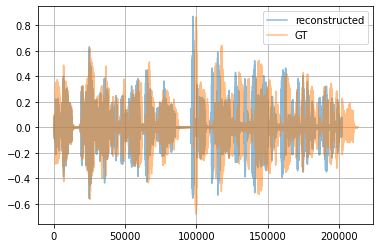

In [221]:
vocoder = Vocoder().to(device).eval()
model.eval()
reconstructed_wav = vocoder.inference(model(tokens, durs)[0][:1].transpose(1, 2)).cpu()
plt.plot(reconstructed_wav[0], label='reconstructed', alpha=.5)
plt.plot(waveform[0], label='GT', alpha=.5)
plt.grid()
plt.legend()
plt.show()

In [223]:
from IPython import display
display.display(display.Audio(waveform[0], rate=22050))
display.display(display.Audio(reconstructed_wav[0], rate=22050))

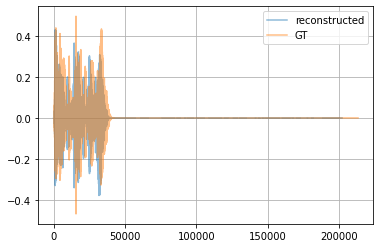

In [224]:
reconstructed_wav = vocoder.inference(model(tokens, durs)[0][1:2].transpose(1, 2)).cpu()
plt.plot(reconstructed_wav[0], label='reconstructed', alpha=.5)
plt.plot(waveform[1], label='GT', alpha=.5)
plt.grid()
plt.legend()
plt.show()

In [225]:
display.display(display.Audio(waveform[1], rate=22050))
display.display(display.Audio(reconstructed_wav[0], rate=22050))

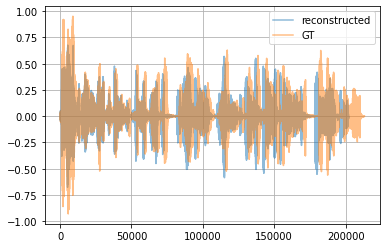

In [226]:
reconstructed_wav = vocoder.inference(model(tokens, durs)[0][2:].transpose(1, 2)).cpu()
plt.plot(reconstructed_wav[0], label='reconstructed', alpha=.5)
plt.plot(waveform[2], label='GT', alpha=.5)
plt.grid()
plt.legend()
plt.show()

In [227]:
display.display(display.Audio(waveform[2], rate=22050))
display.display(display.Audio(reconstructed_wav[0], rate=22050))